# Desafio

**Análise exploratória**

AE-1 - Carregue os dados em um DataFrame pandas.  
AE-2 - Analise e responda qual foi o crescimento das vendas (VendasSupermercados) dos últimos 12 meses (Set/2022 - Agosto 2023 vs Set/2021 - Agosto 2022)?
AE-3 - Analise e responda se existe sazonalidade e tendência nesses dados? Como você descreveria e mostraria graficamente?
AE-4 - Analise e responda se existe relação entre o CDI e as vendas? Como você a descreveria e mostraria graficamente?
    
**Modelagem** 

M-1 - Usando uma biblioteca de sua escolha, treine dois modelos de machine learning,
um ARIMA e outro multivariado, para prever as vendas de supermercados.
M-2 - Como você usou esses dados (vendas, cdi e datas) para criar variáveis?
M-3 - Faça a modelagem numa estratégia de validação com 2 backtests. Calcule o MAPE (Mean absolute percentage error) 
    para cada um desses backtests e reporte a média dos MAPEs. Explique como definiu o tamanho do backtest 
    (por exemplo:3,6,12 ou 24 meses).
M-4- Faça a previsão dos próximos 12 meses e crie um gráfico de linhas (eixo X = date, eixo Y VendasSupermercados/Previsões)
    mostrando 1) os últimos 4 anos de histórico de vendas, 2) as projeções dos 2 backtests, 3) o ano projetado. 

In [276]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pmdarima.arima import auto_arima
from pmdarima.arima.arima import ARIMA
from scipy.stats import kendalltau
from scipy.stats import kurtosis
from scipy.stats import probplot
from scipy.stats import skew
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import DecomposeResult
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss

# Análise Exploratória do Dados

## Importamos os Dados --> AE-1

In [277]:
path_to_csv_file: str = "./VendasSupermercados+CDI.csv"

In [278]:
super_market_df: pd.DataFrame = pd.read_csv(
    filepath_or_buffer=path_to_csv_file,
    delimiter=";"
)

super_market_df.head()

,Date,VendasSupermercados,CDI
0,2010-01-01,76.39,0.66
1,2010-02-01,73.95,0.59
2,2010-03-01,81.69,0.76
3,2010-04-01,77.91,0.66
4,2010-05-01,78.66,0.75


## Verificamos Tipo de Dados

In [279]:
super_market_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 164 non-null    object 
 1   VendasSupermercados  164 non-null    float64
 2   CDI                  164 non-null    float64
dtypes: float64(2), object(1)
memory usage: 4.0+ KB


*O campo Date deve ser convertido para o tipo data*

## Convertemos o Campos "DATE" para data

In [280]:
super_market_df["Date"]: pd.Series = pd.to_datetime(super_market_df["Date"])
super_market_df.dtypes

Date                   datetime64[ns]
VendasSupermercados           float64
CDI                           float64
dtype: object

## Verificamos Valores em Branco

In [281]:
super_market_df.isnull().sum()

Date                   0
VendasSupermercados    0
CDI                    0
dtype: int64

## Verificamos se Temos Datas Repetidas

In [282]:
super_market_df["Date"].value_counts()

Date
2010-01-01    1
2018-08-01    1
2018-10-01    1
2018-11-01    1
2018-12-01    1
             ..
2014-08-01    1
2014-09-01    1
2014-10-01    1
2014-11-01    1
2023-08-01    1
Name: count, Length: 164, dtype: int64

## Obtemos uma Visão Topológica das Variáveis

In [283]:
super_market_df.describe()

,Date,VendasSupermercados,CDI
count,164,164.000000,164.000000
mean,2016-10-15 19:19:01.463414528,93.174329,0.738537
min,2010-01-01 00:00:00,73.950000,0.130000
25%,2013-05-24 06:00:00,88.070000,0.537500
50%,2016-10-16 12:00:00,91.700000,0.785000
75%,2020-03-08 18:00:00,97.612500,0.952500
max,2023-08-01 00:00:00,122.750000,1.210000
std,NaN,9.001255,0.281626


## Criamos as Séries

In [284]:
super_market_df.set_index(
    keys="Date",
    inplace=True
)

In [285]:
super_market_df

,VendasSupermercados,CDI
Date,,
2010-01-01,76.39,0.66
2010-02-01,73.95,0.59
2010-03-01,81.69,0.76
2010-04-01,77.91,0.66
2010-05-01,78.66,0.75
...,...,...
2023-04-01,103.95,0.92
2023-05-01,98.53,1.12
2023-06-01,99.43,1.07


## Separamos as Séries

In [286]:
df_sales: pd.DataFrame = super_market_df.drop(
    labels="CDI",
    axis=1
)

df_cdi: pd.DataFrame = super_market_df.drop(
    labels="VendasSupermercados",
    axis=1
)

In [287]:
df_sales.head()

,VendasSupermercados
Date,
2010-01-01,76.39
2010-02-01,73.95
2010-03-01,81.69
2010-04-01,77.91
2010-05-01,78.66


In [288]:
df_cdi.head()

,CDI
Date,
2010-01-01,0.66
2010-02-01,0.59
2010-03-01,0.76
2010-04-01,0.66
2010-05-01,0.75


## Verificamos Crescimento Entre Períodos --> AE-2

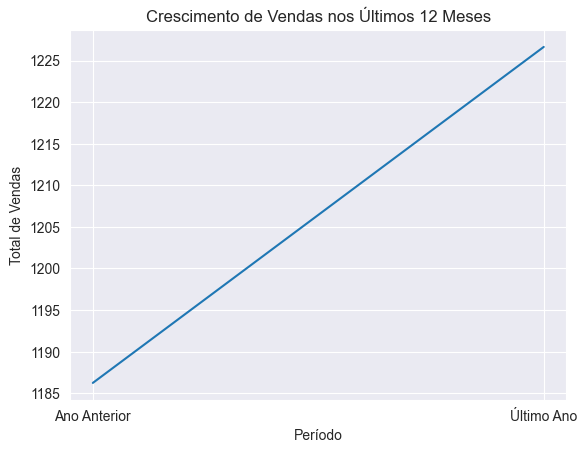

Taxa de Crescimento: 3.41%


In [289]:
last_year_data: pd.DataFrame = super_market_df.loc["2022-09-01":"2023-08-31"]

previous_year_data: pd.DataFrame = super_market_df.loc["2021-09-01":"2022-08-31"]

last_year_sales: float = last_year_data["VendasSupermercados"].sum()
previous_year_sales: float = previous_year_data["VendasSupermercados"].sum()

growth_rate: float = ((last_year_sales - previous_year_sales) / previous_year_sales) * 100

plt.plot(
    ["Ano Anterior", "Último Ano"],
    [previous_year_sales, last_year_sales]
)

plt.xlabel(xlabel="Período")
plt.ylabel(ylabel="Total de Vendas")
plt.title(label="Crescimento de Vendas nos Últimos 12 Meses")
plt.grid(visible=True)
plt.show()

print(f"Taxa de Crescimento: {growth_rate:.2f}%")

## Plotamos as Séries

<Axes: xlabel='Date'>

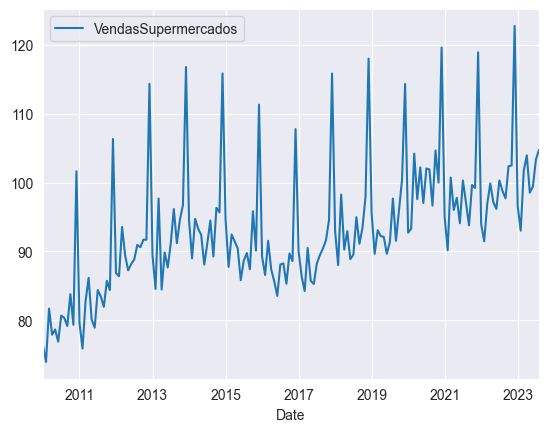

In [290]:
df_sales.plot()

<Axes: xlabel='Date'>

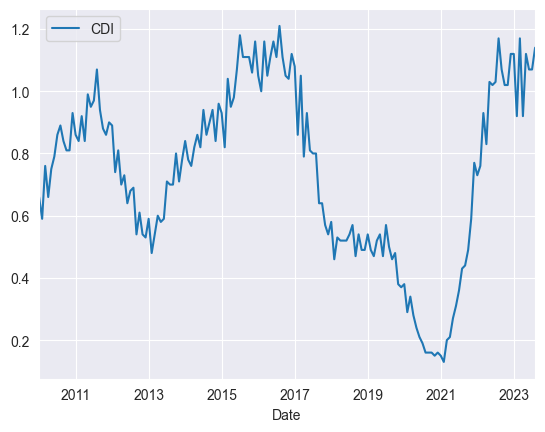

In [291]:
df_cdi.plot()

## Plotamos os Histogramas

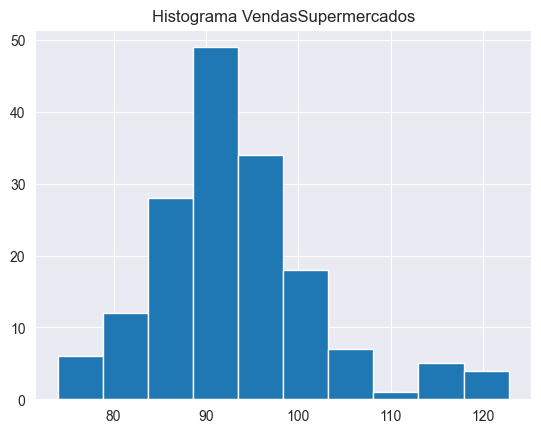

In [292]:
super_market_df["VendasSupermercados"].hist()
plt.title(label="Histograma VendasSupermercados")
plt.show()

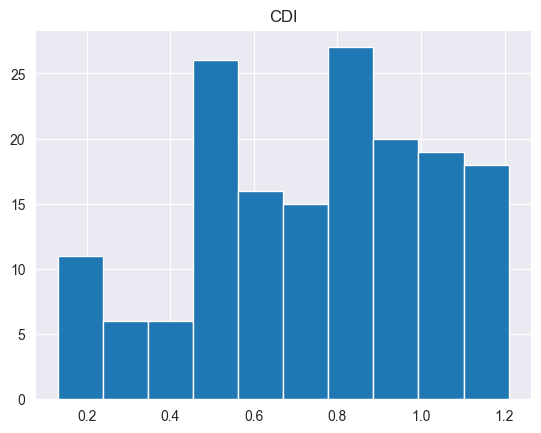

In [293]:
super_market_df["CDI"].hist()
plt.title(label="CDI")
plt.show()

## Verificamos Normalidade | N > 50

In [294]:
def check_data_normality(
        dataframe: pd.DataFrame,
        fields_list: list[str]
):
    for field in fields_list:
        print("------------------------------------------")
        print("Field", field)

        result_skewness = skew(super_market_df[field])

        print(f"Skewness: {result_skewness}")

        if result_skewness > 0:
            print("The distribution is positively skewed (long right tail).")
        elif result_skewness < 0:
            print("The distribution is negatively skewed (long left tail).")
        else:
            print("The distribution is symmetric.")

        result_kurtosis = kurtosis(super_market_df[field])

        print(f"Kurtosis: {result_kurtosis}")

        if result_kurtosis > 3:
            print("The distribution is leptokurtic (more peaks and heavier tails).")
        elif result_kurtosis < 3:
            print("The distribution is platykurtic (fewer peaks and lighter tails).")
        else:
            print("The distribution is normal (mesokurtic).")

In [295]:
check_data_normality(
    dataframe=super_market_df,
    fields_list=["VendasSupermercados", "CDI"]
)

------------------------------------------
Field VendasSupermercados
Skewness: 0.8223753759418065
The distribution is positively skewed (long right tail).
Kurtosis: 1.2214275839536084
The distribution is platykurtic (fewer peaks and lighter tails).
------------------------------------------
Field CDI
Skewness: -0.3561285798230702
The distribution is negatively skewed (long left tail).
Kurtosis: -0.7687677530263093
The distribution is platykurtic (fewer peaks and lighter tails).


### Vendas QQ Plot

((array([-2.63413573, -2.31756952, -2.13647436, -2.00644483, -1.90348837,
         -1.81747188, -1.74311842, -1.67731464, -1.61806304, -1.56400219,
         -1.51416067, -1.46781996, -1.42443297, -1.38357308, -1.34490085,
         -1.30814157, -1.27306962, -1.23949733, -1.20726678, -1.17624382,
         -1.1463134 , -1.11737612, -1.08934544, -1.06214553, -1.03570956,
         -1.00997826, -0.98489888, -0.96042416, -0.93651163, -0.91312298,
         -0.89022347, -0.86778152, -0.84576834, -0.82415758, -0.80292503,
         -0.78204843, -0.76150725, -0.74128246, -0.72135645, -0.70171283,
         -0.68233632, -0.66321268, -0.64432857, -0.62567149, -0.60722971,
         -0.58899218, -0.57094849, -0.55308881, -0.53540384, -0.51788476,
         -0.50052321, -0.48331124, -0.46624128, -0.44930612, -0.43249886,
         -0.41581289, -0.39924191, -0.38277985, -0.36642088, -0.35015939,
         -0.33398997, -0.31790742, -0.30190667, -0.28598286, -0.27013124,
         -0.25434721, -0.2386263 , -0.

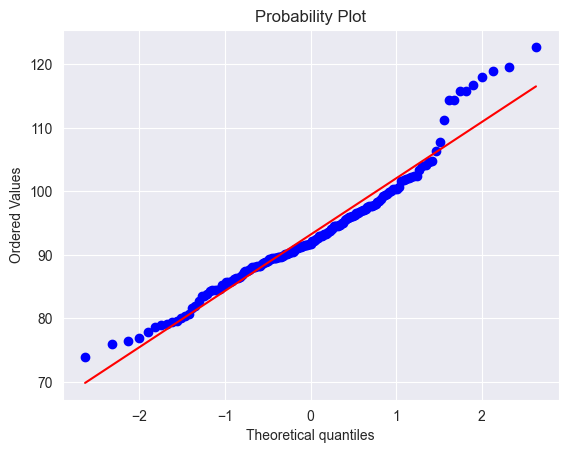

In [296]:
probplot(
    x=df_sales["VendasSupermercados"],
    dist="norm",
    plot=plt
)

### CDI QQ Plot

((array([-2.63413573, -2.31756952, -2.13647436, -2.00644483, -1.90348837,
         -1.81747188, -1.74311842, -1.67731464, -1.61806304, -1.56400219,
         -1.51416067, -1.46781996, -1.42443297, -1.38357308, -1.34490085,
         -1.30814157, -1.27306962, -1.23949733, -1.20726678, -1.17624382,
         -1.1463134 , -1.11737612, -1.08934544, -1.06214553, -1.03570956,
         -1.00997826, -0.98489888, -0.96042416, -0.93651163, -0.91312298,
         -0.89022347, -0.86778152, -0.84576834, -0.82415758, -0.80292503,
         -0.78204843, -0.76150725, -0.74128246, -0.72135645, -0.70171283,
         -0.68233632, -0.66321268, -0.64432857, -0.62567149, -0.60722971,
         -0.58899218, -0.57094849, -0.55308881, -0.53540384, -0.51788476,
         -0.50052321, -0.48331124, -0.46624128, -0.44930612, -0.43249886,
         -0.41581289, -0.39924191, -0.38277985, -0.36642088, -0.35015939,
         -0.33398997, -0.31790742, -0.30190667, -0.28598286, -0.27013124,
         -0.25434721, -0.2386263 , -0.

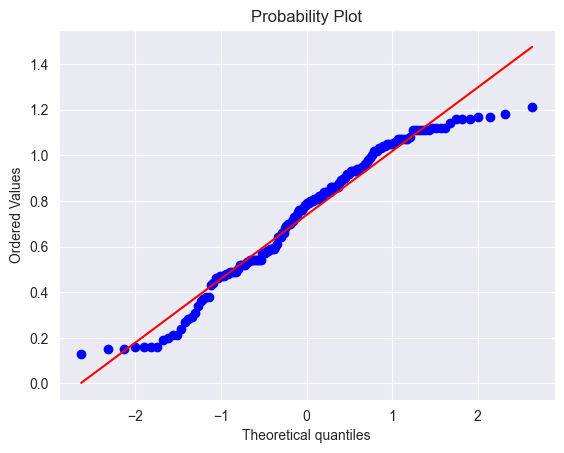

In [297]:
probplot(
    x=df_cdi["CDI"],
    dist="norm",
    plot=plt
)

## Realizamos a Decomposição das Seriés

In [298]:
df_sales_decompose: DecomposeResult = seasonal_decompose(x=df_sales)
df_cdi_decompose: DecomposeResult = seasonal_decompose(x=df_cdi)

### Vendas - Decomposição

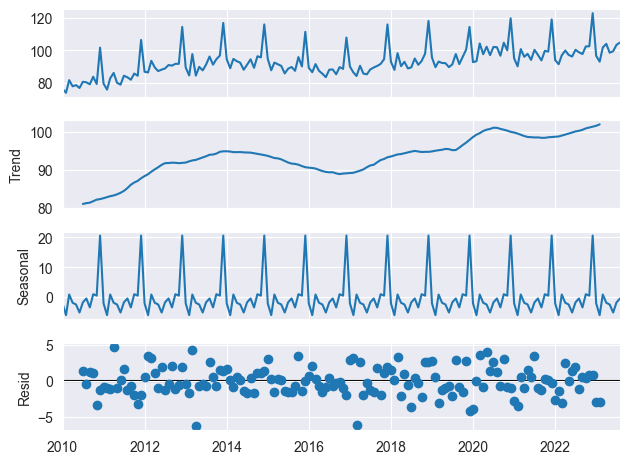

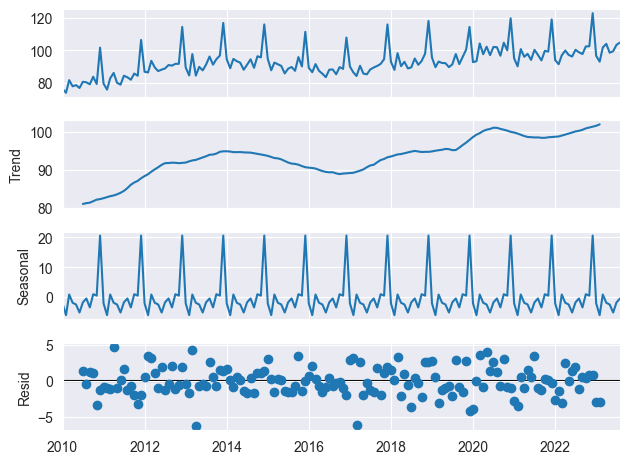

In [299]:
df_sales_decompose.plot()

### CDI - Decomposição

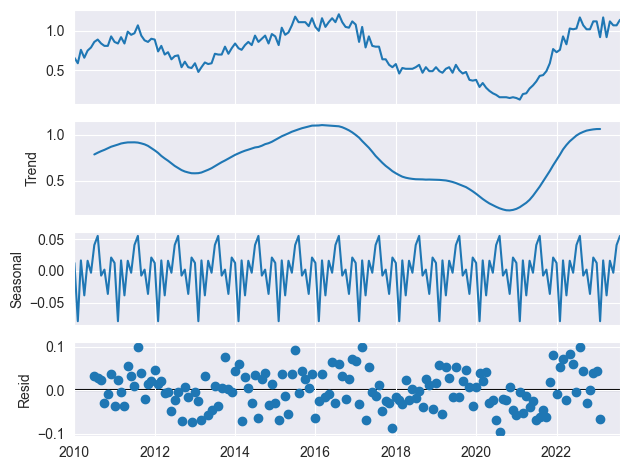

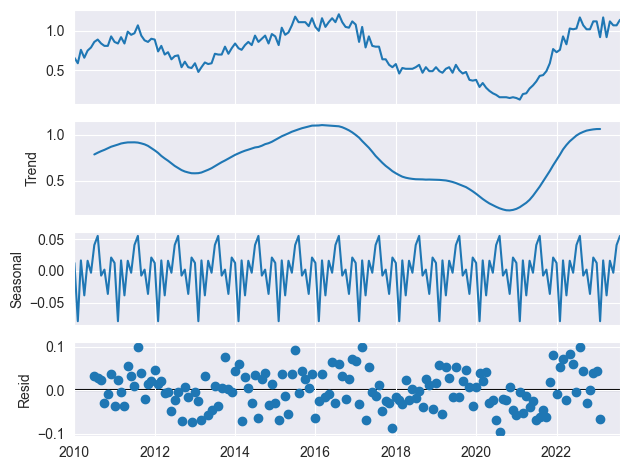

In [300]:
df_cdi_decompose.plot()

In [301]:
def check_data_trend(
        dataframe: pd.DataFrame,
        fields_name_list: list[str]
):
    for field in fields_name_list:
        print("--------------------------------------")
        print("Field: ", field)

        tau, p_value = kendalltau(dataframe[field], range(len(dataframe)))
        print(f'Test Statistic (Tau): {tau}\nP-Value: {p_value}')

        if p_value <= 0.05:
            print("Há evidências estatísticas de uma tendência.")
        else:
            print("Não há evidências estatísticas de uma tendência significativa.")


In [302]:
check_data_trend(
    dataframe=super_market_df,
    fields_name_list=["VendasSupermercados", "CDI"]
)

--------------------------------------
Field:  VendasSupermercados
Test Statistic (Tau): 0.4952096307783412
P-Value: 5.054723434674881e-21
Há evidências estatísticas de uma tendência.
--------------------------------------
Field:  CDI
Test Statistic (Tau): -0.13218143374987404
P-Value: 0.012549021054553692
Há evidências estatísticas de uma tendência.


### Descrevendo Observações --> AE-3 

Para vendas os dados apresentam tendência e sazonalidade bem evidêntes, mas para CDI os dados apresentam 
sazonalidade evidente e tendência fraca.

## Verificamos Estacionariedade

In [303]:
def check_kpss(
        dataframe: pd.DataFrame,
        field_name: str
):
    kpss_result: tuple = kpss(dataframe[field_name])
    print("KPSS Result: ", kpss_result)

### Vendas

In [304]:
check_kpss(
    dataframe=df_sales,
    field_name="VendasSupermercados"
)

KPSS Result:  (1.4788548291147696, 0.01, 7, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\Lucas Praciano\AppData\Local\Temp\ipykernel_18712\2959042198.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result: tuple = kpss(dataframe[field_name])


### CDI

In [305]:
check_kpss(
    dataframe=df_cdi,
    field_name="CDI"
)

KPSS Result:  (0.28348991858659334, 0.1, 8, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\Lucas Praciano\AppData\Local\Temp\ipykernel_18712\2959042198.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result: tuple = kpss(dataframe[field_name])


## Verificamos Correlação Entre Variáveis

In [306]:
df_correlation: pd.DataFrame = super_market_df.reset_index()
df_correlation

,Date,VendasSupermercados,CDI
0,2010-01-01,76.39,0.66
1,2010-02-01,73.95,0.59
2,2010-03-01,81.69,0.76
3,2010-04-01,77.91,0.66
4,2010-05-01,78.66,0.75
...,...,...,...
159,2023-04-01,103.95,0.92
160,2023-05-01,98.53,1.12
161,2023-06-01,99.43,1.07
162,2023-07-01,103.35,1.07


In [307]:
df_correlation: pd.DataFrame = df_correlation[
    [
        "Date",
        "VendasSupermercados",
        "CDI"
    ]
].corr()

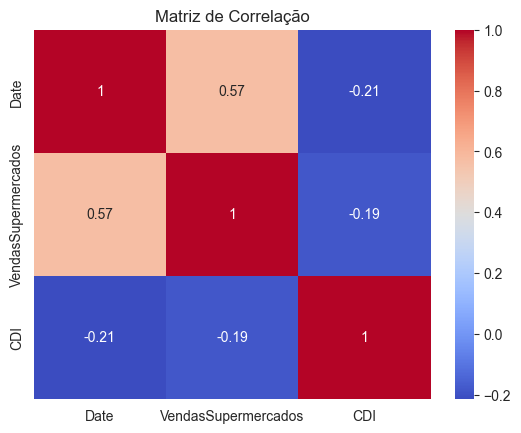

In [308]:
sns.heatmap(
    data=df_correlation,
    annot=True,
    cmap="coolwarm"
)
plt.title(label="Matriz de Correlação")
plt.show()

### Descrevendo Observações --> AE-4 

Podemos observar correlação:
 
Moderadamente forte, entre: 
    1 - Date x VendasSupermercados 
    
Fraca, entre:
    1 - Date x CDI
    2 - CDI x VendasSupermercados

## Verificamos Autocorrelação

### Vendas

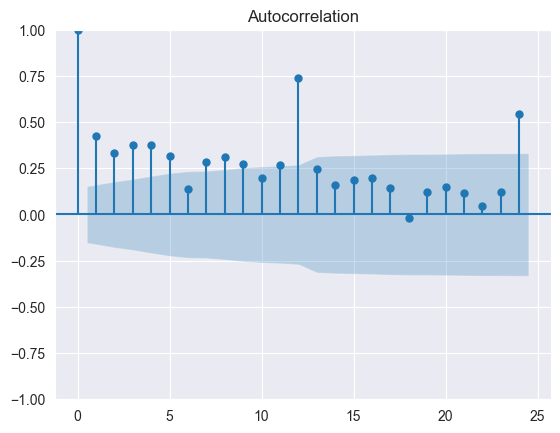

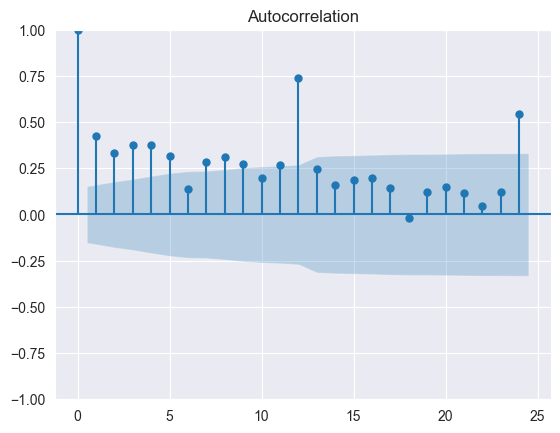

In [309]:
plot_acf(
    x=df_sales,
    lags=24
)

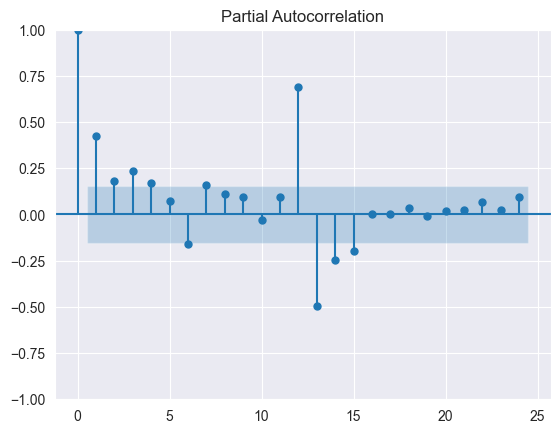

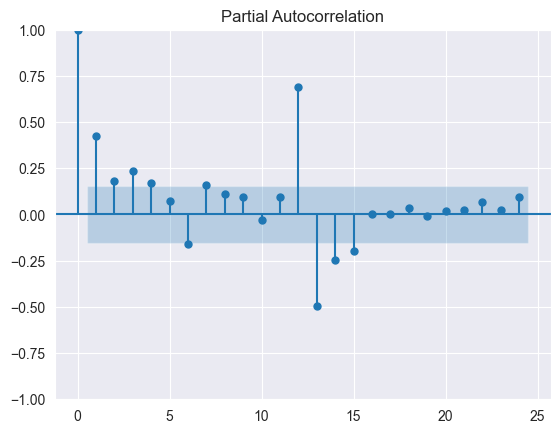

In [310]:
plot_pacf(
    x=df_sales,
    lags=24
)

### CDI

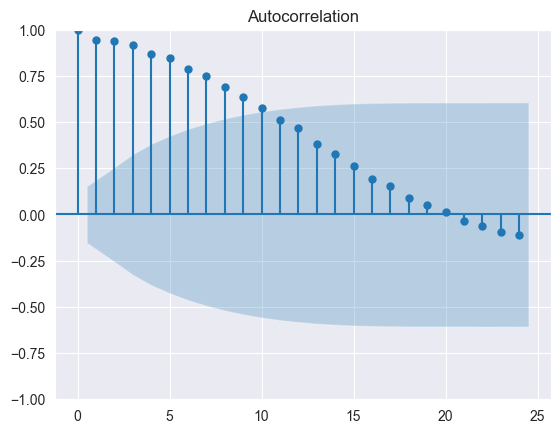

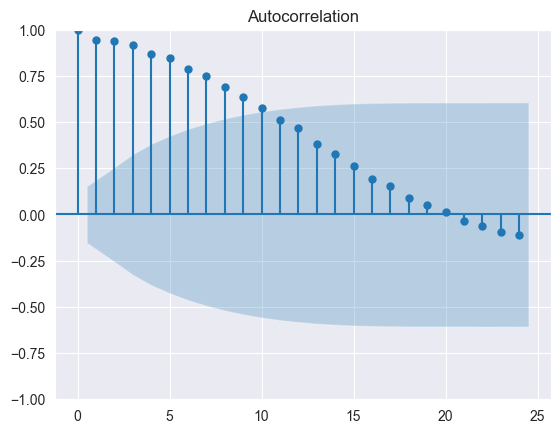

In [311]:
plot_acf(
    x=df_cdi,
    lags=24
)

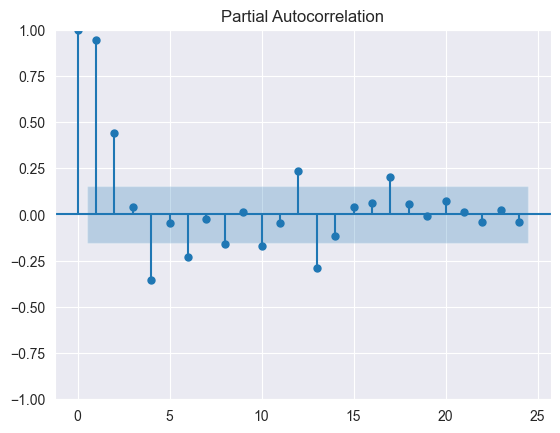

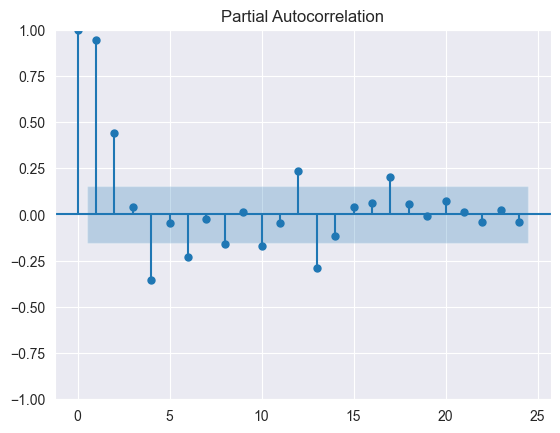

In [312]:
plot_pacf(
    x=df_cdi,
    lags=24
)

# Modelos

## ARIMA

In [313]:
### Carregado Dados
df_arima_sales: pd.DataFrame = df_sales.copy()
df_arima_cdi: pd.DataFrame = df_cdi.copy()

In [314]:
df_arima_sales

,VendasSupermercados
Date,
2010-01-01,76.39
2010-02-01,73.95
2010-03-01,81.69
2010-04-01,77.91
2010-05-01,78.66
...,...
2023-04-01,103.95
2023-05-01,98.53
2023-06-01,99.43


In [315]:
df_arima_cdi

,CDI
Date,
2010-01-01,0.66
2010-02-01,0.59
2010-03-01,0.76
2010-04-01,0.66
2010-05-01,0.75
...,...
2023-04-01,0.92
2023-05-01,1.12
2023-06-01,1.07


### Transformando Dados

#### Reduzindo Variância

In [316]:
df_arima_sales["VendasSupermercados"]: pd.Series = df_arima_sales["VendasSupermercados"] ** (1/3)
df_arima_cdi["CDI"]: pd.Series = df_arima_cdi["CDI"] ** (1/3)

In [317]:
df_arima_sales

,VendasSupermercados
Date,
2010-01-01,4.243057
2010-02-01,4.197391
2010-03-01,4.339000
2010-04-01,4.271015
2010-05-01,4.284676
...,...
2023-04-01,4.701916
2023-05-01,4.618733
2023-06-01,4.632753


### Dividindo Dados

In [318]:
df_train_12: pd.DataFrame = df_arima_sales.iloc[:-12]
df_train_24: pd.DataFrame = df_arima_sales.iloc[:-24]
df_test_12: pd.DataFrame = df_arima_sales.iloc[-12:]
df_test_24: pd.DataFrame = df_arima_sales.iloc[-24:]

In [319]:
df_train_12

,VendasSupermercados
Date,
2010-01-01,4.243057
2010-02-01,4.197391
2010-03-01,4.339000
2010-04-01,4.271015
2010-05-01,4.284676
...,...
2022-04-01,4.639577
2022-05-01,4.597226
2022-06-01,4.581558


In [320]:
df_train_24

,VendasSupermercados
Date,
2010-01-01,4.243057
2010-02-01,4.197391
2010-03-01,4.339000
2010-04-01,4.271015
2010-05-01,4.284676
...,...
2021-04-01,4.579175
2021-05-01,4.607141
2021-06-01,4.548448


In [321]:
df_test_12

,VendasSupermercados
Date,
2022-09-01,4.605884
2022-10-01,4.678124
2022-11-01,4.679494
2022-12-01,4.969818
2023-01-01,4.588060
2023-02-01,4.530980
2023-03-01,4.668049
2023-04-01,4.701916
2023-05-01,4.618733


In [322]:
df_test_24

,VendasSupermercados
Date,
2021-09-01,4.543447
2021-10-01,4.636167
2021-11-01,4.629334
2021-12-01,4.917444
2022-01-01,4.546675
2022-02-01,4.505672
2022-03-01,4.593279
2022-04-01,4.639577
2022-05-01,4.597226


### Criando Modelo 12m

In [323]:
def calculate_mean_absolute_percentage_error(
        y_true: pd.Series | list | np.ndarray,
        y_pred: pd.Series | list | np.ndarray
) -> float:
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [324]:
arima_model_12: ARIMA = auto_arima(
    df_train_12["VendasSupermercados"],
    trace=True,
    stepwise=False,
    seasonal=True,
    approxomation=False,
    m=12
)

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-147.448, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.561, Time=0.09 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-221.559, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-311.568, Time=0.20 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=-356.776, Time=0.36 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-434.268, Time=0.23 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=-461.754, Time=0.39 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=-460.482, Time=0.80 sec
 ARIMA(0,1,1)(2,0,0)[12] inter

In [325]:
arima_model_12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  152
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 12)   Log Likelihood                 247.314
Date:                              Fri, 02 Feb 2024   AIC                           -482.628
Time:                                      15:58:44   BIC                           -464.525
Sample:                                  01-01-2010   HQIC                          -475.274
                                       - 08-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -5.734e-06      0.000     -0.053      0.958      -0.000       0.000
ar.L1         -0.7217      0.072    -10.020      0.000      -0.863      -0.581
ar.L2         -0.3836      0.091     -4.212      0.000      -0.562      -0.205
ar.S.L12       0.9966      0.003    337.413      0.000       0.991       1.002
ma.S.L12      -0.7913      0.080     -9.901      0.000      -0.948      -0.635
sigma2         0.0017      0.000      8.916      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 6.09
Prob(Q):                              0.95   Prob(JB):                         0.05
Heteroskedasticity (H):               0.97   Skew:                             0.09
Prob(H) (two-sided):                  0.92   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [328]:
predict_12: pd.Series = arima_model_12.predict(
    n_periods=len(df_test_12["VendasSupermercados"])
)
predict_12

2022-09-01    4.596411
2022-10-01    4.670546
2022-11-01    4.661515
2022-12-01    4.954301
2023-01-01    4.613599
2023-02-01    4.555707
2023-03-01    4.668858
2023-04-01    4.633735
2023-05-01    4.633661
2023-06-01    4.590922
2023-07-01    4.651024
2023-08-01    4.662584
Freq: MS, dtype: float64

In [329]:
mean_absolute_percentage_error_12: float = calculate_mean_absolute_percentage_error(
    y_true=df_test_12["VendasSupermercados"],
    y_pred=predict_12
)

print(f"MAPE_12 is: {round(mean_absolute_percentage_error_12, 2)}%")

MAPE_12 is: 0.57%


<Axes: xlabel='Date'>

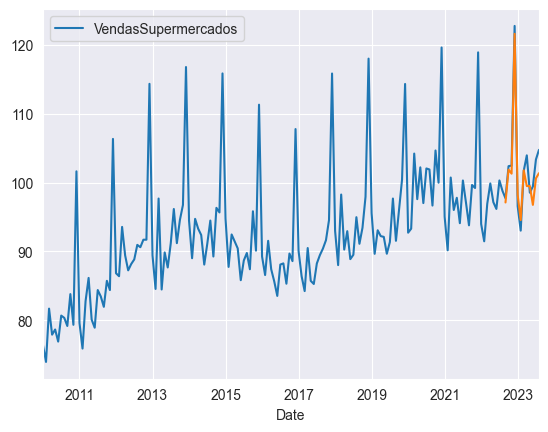

In [330]:
df_sales.plot()
(predict_12**3).plot()

### Criando Modelo 24m

In [326]:
arima_model_24: ARIMA = auto_arima(
    df_train_24["VendasSupermercados"],
    trace=True,
    stepwise=False,
    seasonal=True,
    approxomation=False,
    m=12
)

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-135.063, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-222.596, Time=0.14 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-377.429, Time=0.29 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=-374.001, Time=0.55 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=-375.719, Time=0.58 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-201.937, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-281.432, Time=0.12 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=-324.408, Time=0.50 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-391.737, Time=0.19 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=-416.443, Time=0.36 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=-409.262, Time=0.39 sec
 ARIMA(0,1,1)(2

In [327]:
arima_model_24.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  140
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 12)   Log Likelihood                 220.809
Date:                              Fri, 02 Feb 2024   AIC                           -429.617
Time:                                      15:59:27   BIC                           -412.010
Sample:                                  01-01-2010   HQIC                          -422.462
                                       - 08-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.103e-05      0.000      0.128      0.898      -0.001       0.001
ar.L1         -0.6706      0.071     -9.501      0.000      -0.809      -0.532
ar.L2         -0.3881      0.089     -4.346      0.000      -0.563      -0.213
ar.S.L12       0.9882      0.007    134.152      0.000       0.974       1.003
ma.S.L12      -0.5615      0.098     -5.715      0.000      -0.754      -0.369
sigma2         0.0020      0.000      8.944      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   1.10   Jarque-Bera (JB):                 4.61
Prob(Q):                              0.29   Prob(JB):                         0.10
Heteroskedasticity (H):               1.13   Skew:                             0.12
Prob(H) (two-sided):                  0.69   Kurtosis:                         3.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [331]:
predict_24: pd.Series = arima_model_24.predict(
    n_periods=len(df_test_24["VendasSupermercados"])
)
predict_24

2021-09-01    4.567521
2021-10-01    4.659357
2021-11-01    4.635415
2021-12-01    4.911813
2022-01-01    4.577951
2022-02-01    4.516145
2022-03-01    4.655836
2022-04-01    4.589693
2022-05-01    4.616561
2022-06-01    4.559596
2022-07-01    4.630101
2022-08-01    4.630674
2022-09-01    4.578819
2022-10-01    4.665835
2022-11-01    4.653656
2022-12-01    4.920595
2023-01-01    4.590439
2023-02-01    4.531991
2023-03-01    4.668424
2023-04-01    4.603182
2023-05-01    4.630337
2023-06-01    4.573655
2023-07-01    4.643414
2023-08-01    4.644134
Freq: MS, dtype: float64

In [332]:
mean_absolute_percentage_error_24: float = calculate_mean_absolute_percentage_error(
    y_true=df_test_24["VendasSupermercados"],
    y_pred=predict_24
)

print(f"MAPE_24 is: {round(mean_absolute_percentage_error_24, 2)}%")

MAPE_24 is: 0.61%


<Axes: xlabel='Date'>

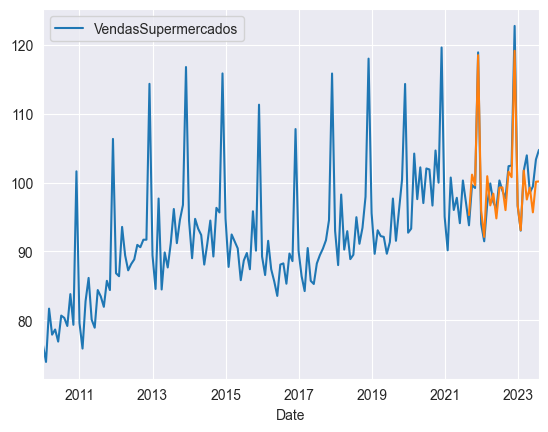

In [333]:
df_sales.plot()
(predict_24**3).plot()

### Predizendo Próximos 12 meses

In [365]:
predict_news_12: pd.Series = arima_model_12.predict(
    n_periods=len(df_test_12["VendasSupermercados"]) + 12
)
predict_news_last_12: pd.Series = predict_news_12.tail(12)
predict_news_last_12

2023-09-01    4.612660
2023-10-01    4.690091
2023-11-01    4.687531
2023-12-01    4.973318
2024-01-01    4.635627
2024-02-01    4.578886
2024-03-01    4.690245
2024-04-01    4.655886
2024-05-01    4.655882
2024-06-01    4.612983
2024-07-01    4.673069
2024-08-01    4.684567
Freq: MS, dtype: float64

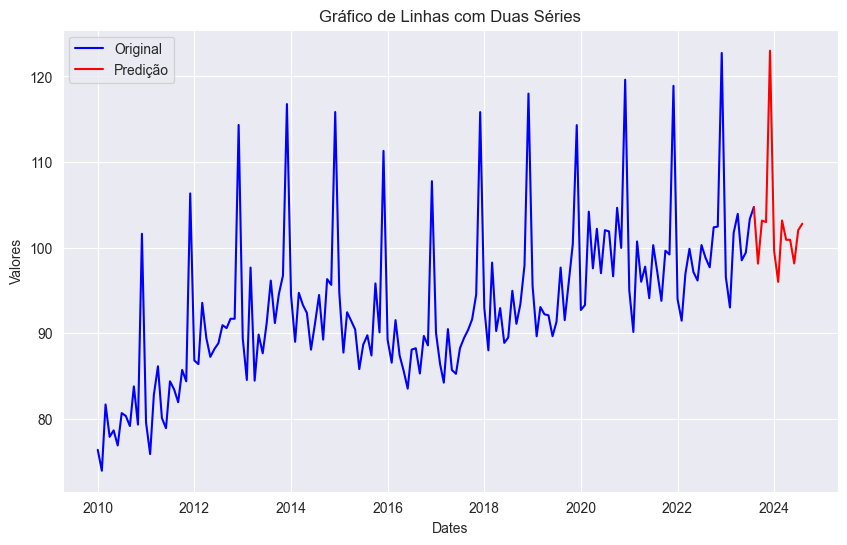

In [414]:
predict_news_last_12_untransformed: pd.Series = predict_news_last_12**3
last_values: pd.Series = df_sales["VendasSupermercados"].tail(1)
predict_news_last_12_untransformed.loc[last_values.index[0]]: float = last_values.values[0]
predict_news_last_12_untransformed.sort_index(inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_sales, label="Original", color="blue")
plt.plot(predict_news_last_12_untransformed, label="Predição", color="red")
plt.xlabel("Dates")
plt.ylabel("Valores") 
plt.title("Gráfico de Linhas com Duas Séries")
plt.legend()
plt.grid(True)
plt.show()